<a href="https://colab.research.google.com/github/mobadata/detection-nouveautes-avis/blob/main/Detection_nouveautes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Importons les packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt_tab')
nltk.download("stopwords")
nltk.download("punkt")
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from bertopic import BERTopic

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# Montons note Google drive dans le notebook
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Importation des données

# Chemin du fichier JSON dans le drive
chemin_fichier = "/content/drive/MyDrive/mon_projet_nouveautes/Electronics_5.json"

# Chargement du fichier (format JSON lignes si Amazon)
df = pd.read_json(chemin_fichier, lines=True)

# Affichage des premières lignes
df.head()


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support",1317254400,"09 29, 2011"


In [5]:

# infos sur les variables
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1689188 entries, 0 to 1689187
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   reviewerID      1689188 non-null  object
 1   asin            1689188 non-null  object
 2   reviewerName    1664458 non-null  object
 3   helpful         1689188 non-null  object
 4   reviewText      1689188 non-null  object
 5   overall         1689188 non-null  int64 
 6   summary         1689188 non-null  object
 7   unixReviewTime  1689188 non-null  int64 
 8   reviewTime      1689188 non-null  object
dtypes: int64(2), object(7)
memory usage: 116.0+ MB


In [7]:
# Apercu statistique des données
df.describe(include='all')


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
count,1689188,1689188,1664458,1689188,1689188,1.689188e+06,1689188,1.689188e+06,1689188
unique,192403,63001,162859,8331,1687169,NaN,1139738,NaN,5277
top,ADLVFFE4VBT8,B007WTAJTO,Amazon Customer,"[0, 0]",,NaN,Works great,NaN,"01 7, 2014"
freq,431,4915,26961,963227,1071,NaN,6784,NaN,3051
mean,NaN,NaN,NaN,NaN,NaN,4.222779e+00,NaN,1.340571e+09,NaN
std,NaN,NaN,NaN,NaN,NaN,1.185632e+00,NaN,6.342451e+07,NaN
min,NaN,NaN,NaN,NaN,NaN,1.000000e+00,NaN,9.292320e+08,NaN
25%,NaN,NaN,NaN,NaN,NaN,4.000000e+00,NaN,1.318118e+09,NaN
50%,NaN,NaN,NaN,NaN,NaN,5.000000e+00,NaN,1.360800e+09,NaN
75%,NaN,NaN,NaN,NaN,NaN,5.000000e+00,NaN,1.385078e+09,NaN


In [9]:
df["reviewText"].head(10)


,reviewText
0,We got this GPS for my husband who is an (OTR)...
1,"I'm a professional OTR truck driver, and I bou..."
2,"Well, what can I say. I've had this unit in m..."
3,"Not going to write a long review, even thought..."
4,I've had mine for a year and here's what we go...
5,I am using this with a Nook HD+. It works as d...
6,The cable is very wobbly and sometimes disconn...
7,This adaptor is real easy to setup and use rig...
8,This adapter easily connects my Nook HD 7&#34;...
9,This product really works great but I found th...


In [7]:
# Nettoyage des données
stop_words = set(stopwords.words('english'))

def nettoyer_texte(texte):
    if isinstance(texte, str):
        texte = texte.lower()  # Met en minuscule
        texte = re.sub(r"[^a-z\s]", "", texte)  # Supprime les caractères non alphabétiques
        tokens = word_tokenize(texte)  # Tokenisation
        mots_utiles = [mot for mot in tokens if mot not in stop_words]  # Supprime les stopwords
        return " ".join(mots_utiles)
    else:
        return ""

In [8]:
# On applique la fonction sur la variable reviewText
df["review_clean"] = df["reviewText"].apply(nettoyer_texte)
df[["reviewText", "review_clean"]].head()

,reviewText,review_clean
0,We got this GPS for my husband who is an (OTR)...,got gps husband otr road trucker impressed shi...
1,"I'm a professional OTR truck driver, and I bou...",im professional otr truck driver bought tnd tr...
2,"Well, what can I say. I've had this unit in m...",well say ive unit truck four days prior garmin...
3,"Not going to write a long review, even thought...",going write long review even thought unit dese...
4,I've had mine for a year and here's what we go...,ive mine year heres got tries route non truck ...


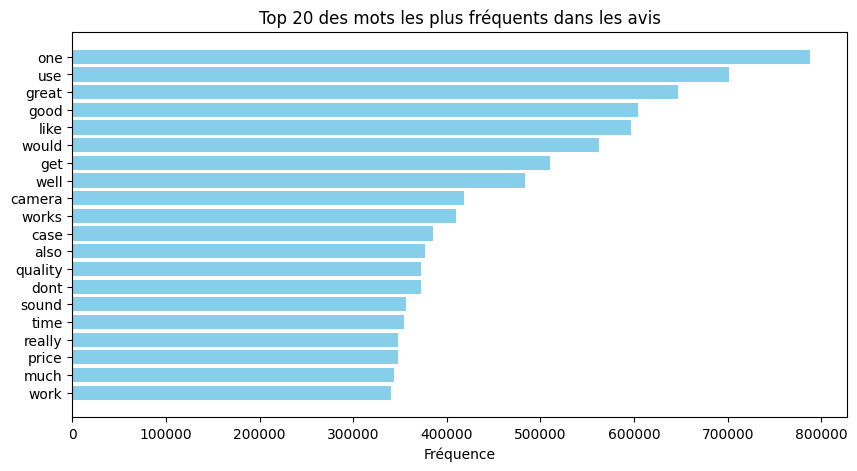

In [21]:

# Récupérer tous les mots des textes nettoyés
tous_les_mots = " ".join(df["review_clean"]).split()

# Compter la fréquence des mots
freq = Counter(tous_les_mots)

# Top 20
top_mots = freq.most_common(20)
mots, counts = zip(*top_mots)

# Affichage
plt.figure(figsize=(10, 5))
plt.barh(mots, counts, color="skyblue")
plt.gca().invert_yaxis()
plt.title("Top 20 des mots les plus fréquents dans les avis")
plt.xlabel("Fréquence")
plt.show()


In [22]:
!pip install bertopic umap-learn hdbscan sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB ? eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 184.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 748.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 548.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 425.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 1.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [10]:
# échantillon de 10000 avis pour tester
df_sample = df.sample(n=10000, random_state=42)

In [11]:
# Création et ajustement du modèle BERTopic
topic_model = BERTopic(language="english")
topics, probs = topic_model.fit_transform(df_sample["review_clean"])


In [12]:
topic_model.get_topic_info().head(10)  # Affiche les 10 thèmes les plus fréquents


,Topic,Count,Name,Representation,Representative_Docs
0,-1,2894,-1_one_cable_use_works,"[one, cable, use, works, camera, great, well, ...",[im novice digital cameras found one easy use ...
1,0,512,0_headphones_ear_sound_ears,"[headphones, ear, sound, ears, headset, bass, ...",[wow looking normal pair headphones actually h...
2,1,436,1_product_item_price_works,"[product, item, price, works, great, good, bou...",[works great easy use price better could find ...
3,2,349,2_speakers_speaker_sound_bass,"[speakers, speaker, sound, bass, volume, sub, ...",[owned number portable rechargeable sound syst...
4,3,279,3_router_wireless_signal_network,"[router, wireless, signal, network, wifi, netg...",[great router allows watch hd quality streamin...
5,4,272,4_card_reader_cards_memory,"[card, reader, cards, memory, sandisk, sd, gb,...",[little sandisk card makes workflow much easie...
6,5,202,5_drive_drives_backup_tb,"[drive, drives, backup, tb, hard, seagate, ext...",[drive plenty fast backup videophoto storage e...
7,6,197,6_protector_screen_bubbles_film,"[protector, screen, bubbles, film, dust, prote...",[others commented unless youre hospital surger...
8,7,193,7_mouse_scroll_wheel_mice,"[mouse, scroll, wheel, mice, logitech, click, ...",[mouse works great pc dell zino pc ubuntu debi...
9,8,157,8_cable_cables_wire_wires,"[cable, cables, wire, wires, connectors, quali...",[purchased cable months ago didnt use decided ...


In [16]:
topic_model.get_topic(1)


[('product', np.float64(0.021037045452008688)),
 ('item', np.float64(0.018966993513853083)),
 ('price', np.float64(0.017071306425188476)),
 ('works', np.float64(0.015677815137177985)),
 ('great', np.float64(0.013976709020351648)),
 ('good', np.float64(0.013552662016416474)),
 ('bought', np.float64(0.012825515531053622)),
 ('working', np.float64(0.012018033947736631)),
 ('buy', np.float64(0.011700512598400877)),
 ('time', np.float64(0.010711108707026644))]

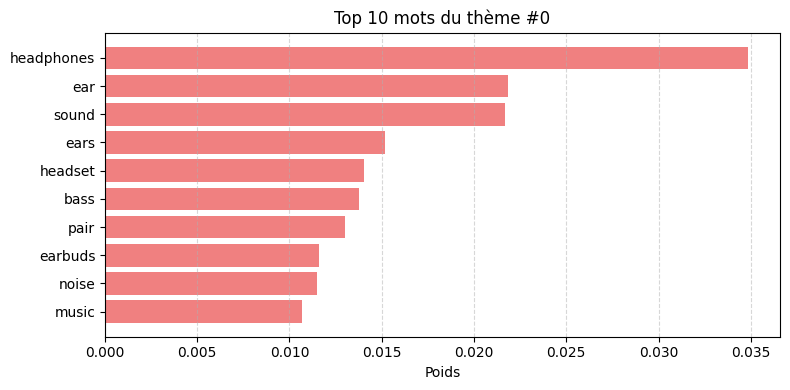

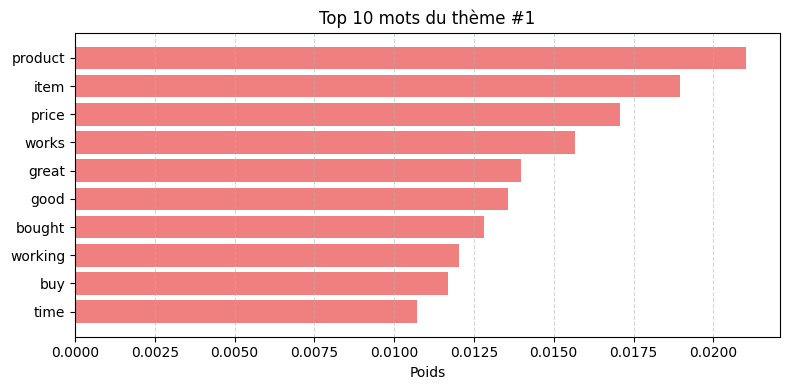

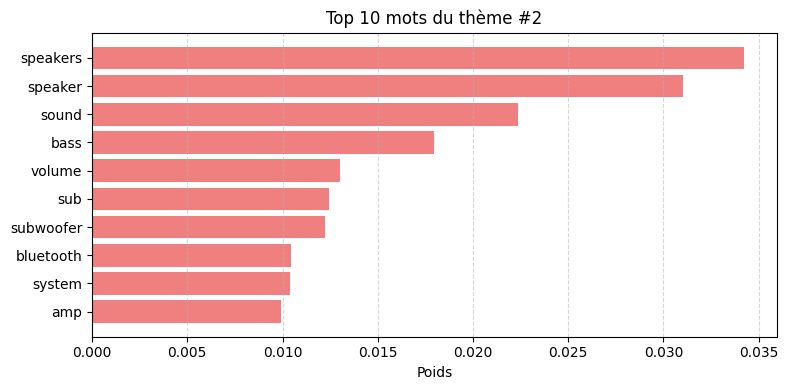

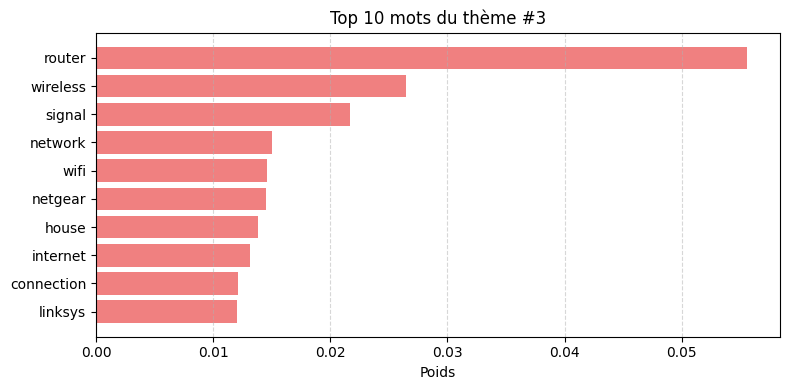

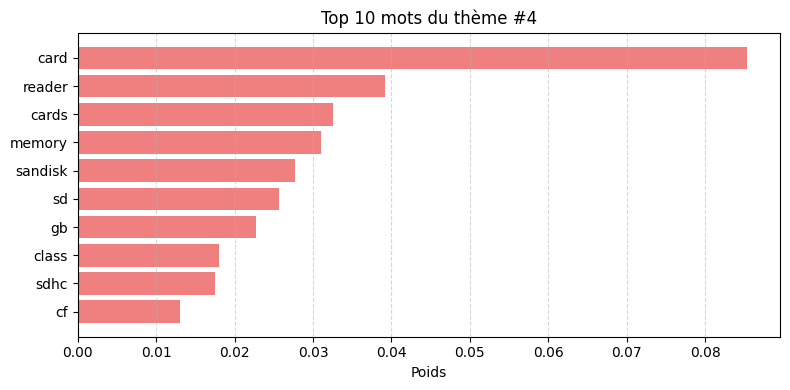

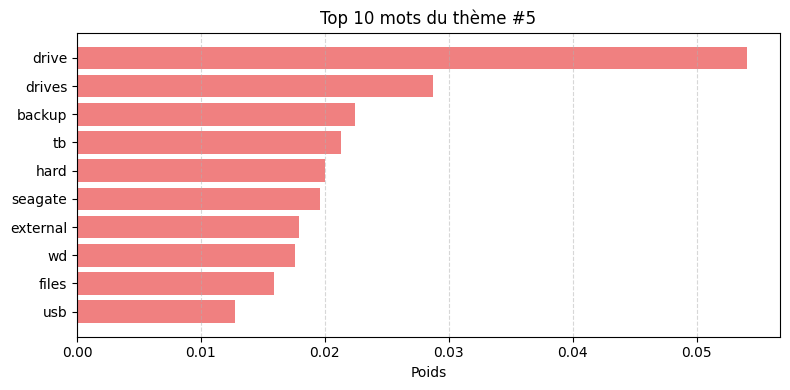

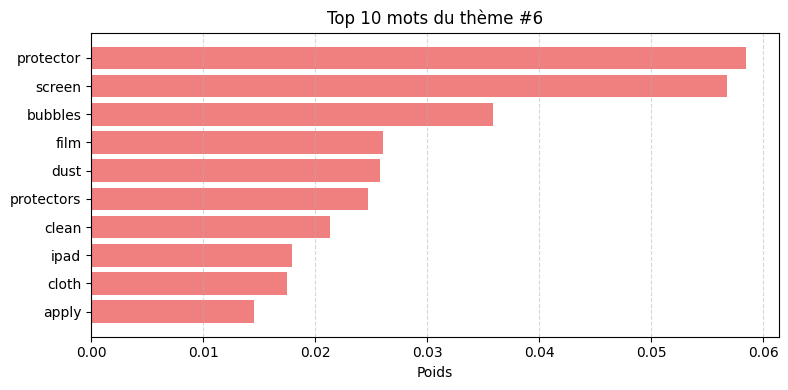

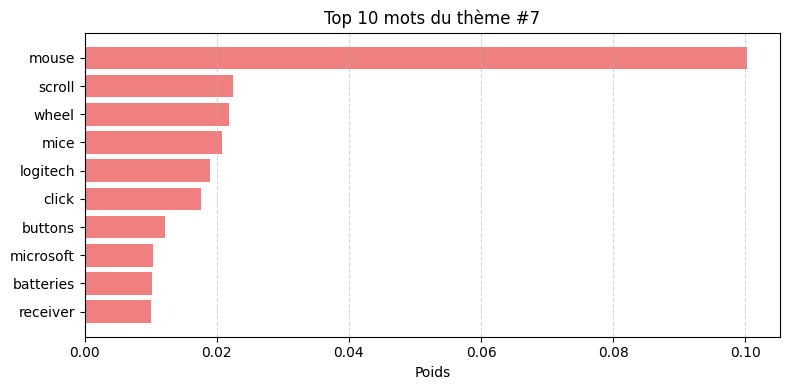

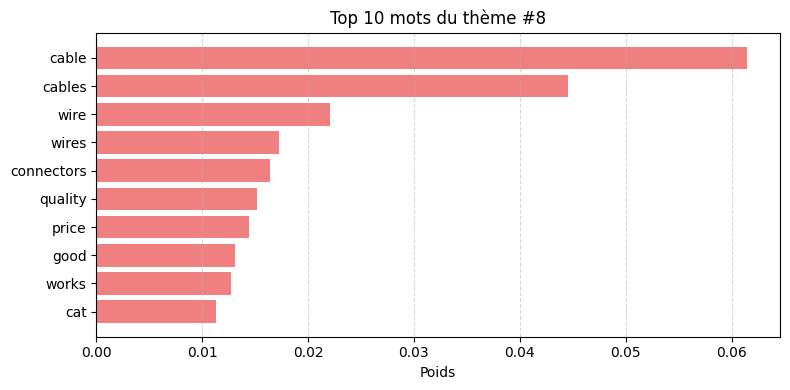

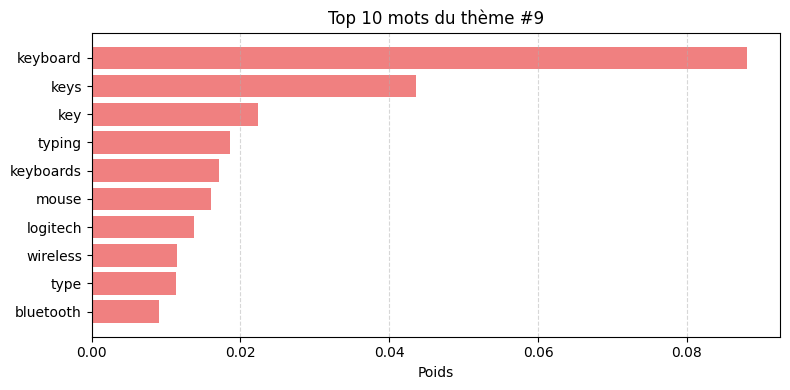

In [15]:
for i in range(10):  # Afficher les 10 premiers topics
    topic_keywords = topic_model.get_topic(i)
    mots = [mot for mot, _ in topic_keywords]
    scores = [score for _, score in topic_keywords]

    plt.figure(figsize=(8, 4))
    plt.barh(mots[:10][::-1], scores[:10][::-1], color="lightcoral")
    plt.xlabel("Poids")
    plt.title(f"Top 10 mots du thème #{i}")
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


In [14]:
# Visualisation interactive des thèmes
topic_model.visualize_topics()


In [17]:
df_sample["reviewTime"] = pd.to_datetime(df_sample["reviewTime"])


In [21]:
df_sample = df_sample.reset_index(drop=True)

In [22]:
topics_over_time = topic_model.topics_over_time(
    docs=df_sample["review_clean"],
    topics=topics,
    timestamps=df_sample["reviewTime"],
    nr_bins=20,         # nombre de périodes (tu peux l’ajuster)
    evolution_tuning=True
)


In [23]:
topic_model.visualize_topics_over_time(topics_over_time)
